# **Machine Learning for Fraud Detection: Examining the Impact of Imbalanced Datasets**

With the rise of buzzwords such as “AI” and “machine learning”, many believe that the role machines will play in the world will only grow exponentially and even threaten human interests. A lack of understanding and fearmongering perpetuates this misconception. In reality, machine learning models rely on datasets to produce results – which highlights the significance of data quality that can be utilized to understand real-world information. This project aims to evaluate and understand the limitations that machine learning models present when introduced to a highly imbalanced dataset.

The dataset used to train the models comes from the PaySim simulator that simulates hourly transactions from a mobile money service for over thirty days. This dataset includes 8,213 fraudulent and 6,354,407 non-fraudulent transactions. The purpose of this project is to see if it is possible to create functional models that correctly predict fraudulent transactions without sacrificing any other aspect so that they may be used in the financial industry without the need for human intervention.

Dataset can be found here: https://www.kaggle.com/datasets/ealaxi/paysim1


In [ ]:
#get dataset
import gdown

file_id = "1Wp9pz6MwQKvrhzvwlKP5PT7lbcELflvh"
url = f"https://drive.google.com/uc?id={file_id}"
output = "PaySim.csv"  # Local filename
gdown.download(url, output, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1Wp9pz6MwQKvrhzvwlKP5PT7lbcELflvh
From (redirected): https://drive.google.com/uc?id=1Wp9pz6MwQKvrhzvwlKP5PT7lbcELflvh&confirm=t&uuid=8dd3aa9b-209c-4d36-a9c8-fbf64977f2e7
To: /content/PaySim.csv
100%|██████████| 494M/494M [00:09<00:00, 50.7MB/s]

File downloaded successfully!


In [ ]:
#load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#read data
paysim_df = pd.read_csv('PaySim.csv')

## 1. EDA

In [ ]:
#check distribution
paysim_df['isFraud'].value_counts()

,count
isFraud,
0,6354407
1,8213


In [ ]:
paysim_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [ ]:
#create fraud and nonfraud data
fraud_df = paysim_df[paysim_df['isFraud'] == 1]
nonfraud_df = paysim_df[paysim_df['isFraud'] == 0]

### a) What types of transactions and how many? Fraud vs non-fraud

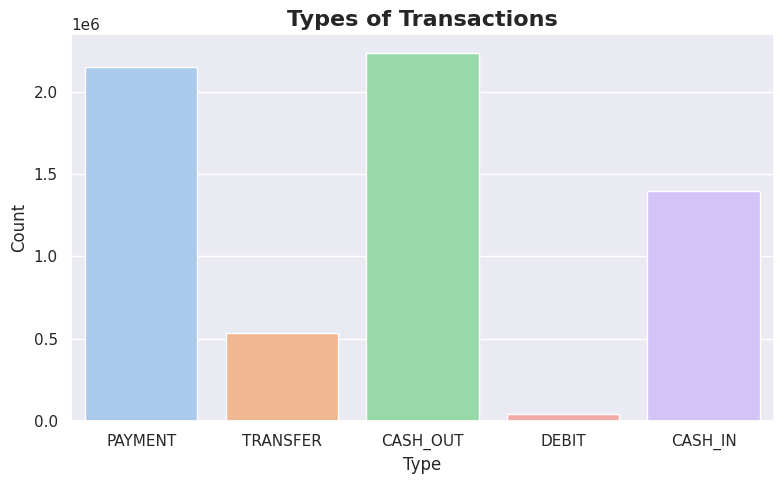

In [ ]:
#plot countplot
sns.set(style="darkgrid")
plt.figure(figsize=(8,5))
sns.countplot(data=paysim_df, x="type", palette='pastel')
plt.title("Types of Transactions", fontsize=16, fontweight='bold')
plt.xlabel("Type", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.tight_layout()
plt.show()


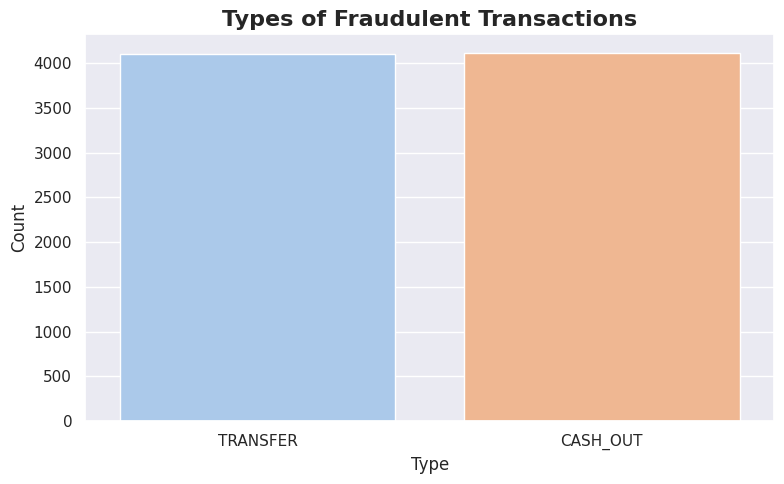

In [ ]:
#plot countplot
plt.figure(figsize=(8,5))
sns.countplot(data=fraud_df, x="type", palette='pastel')
plt.title("Types of Fraudulent Transactions", fontsize=16, fontweight='bold')
plt.xlabel("Type", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.tight_layout()
plt.show()

There are five types of transactions: payment, transfer, cash-in, cash-out, and debit. Fraudulent transactions occur only as transfer or cash-out types. They are almost equal in number.

### b) Overall distributions between transaction amounts? Fraud vs non-fraud

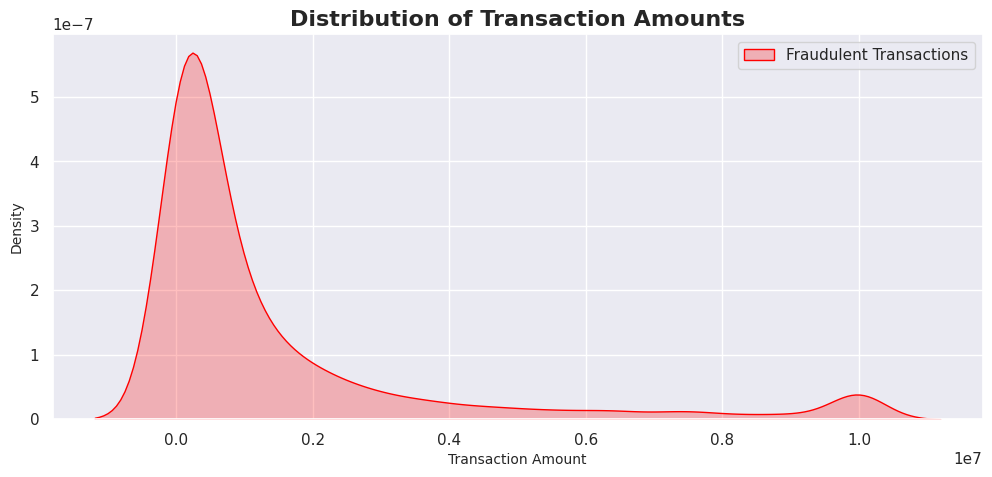

In [ ]:
#plot kdeplot
plt.figure(figsize=(12, 5))
sns.kdeplot(data=fraud_df, x="amount", label="Fraudulent Transactions", fill=True, color="red", common_norm=False)
plt.title("Distribution of Transaction Amounts", fontsize=16, fontweight='bold')
plt.xlabel("Transaction Amount", fontsize=10)
plt.ylabel("Density", fontsize=10)
plt.legend()
plt.show()

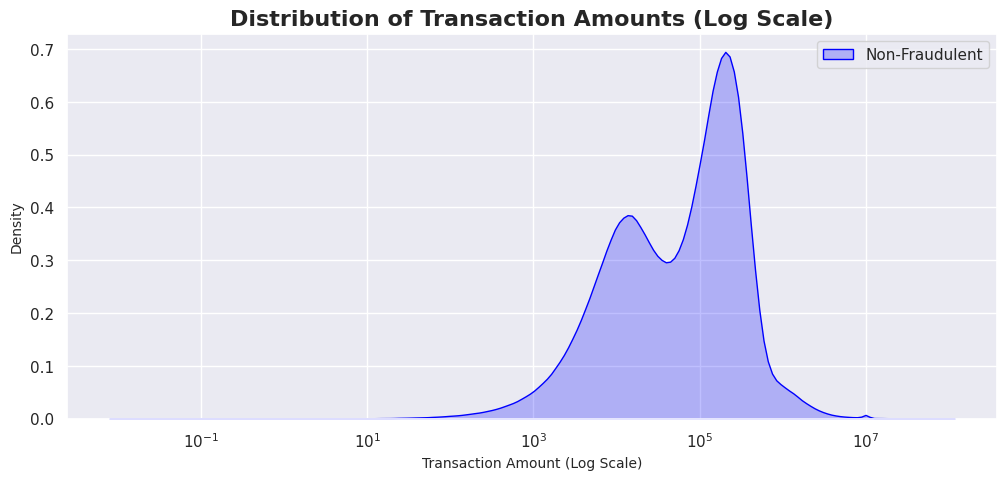

In [ ]:
#plot kdeplot
plt.figure(figsize=(12, 5))
sns.kdeplot(data=nonfraud_df, x="amount", label="Non-Fraudulent", fill=True, log_scale=True, color="blue", common_norm=False)
plt.title("Distribution of Transaction Amounts (Log Scale)", fontsize=16, fontweight='bold')
plt.xlabel("Transaction Amount (Log Scale)", fontsize=10)
plt.ylabel("Density", fontsize=10)
plt.legend()
plt.show()

For the graph above, I used a logarithmic scale to smooth out the data since there was a wide range of transaction amounts. Here the peaks show that non-fraudulent transactions can occur in high amounts – confirming that the amount itself need not be an indicator of fraud.

### c) Which accounts are more involved in frauds

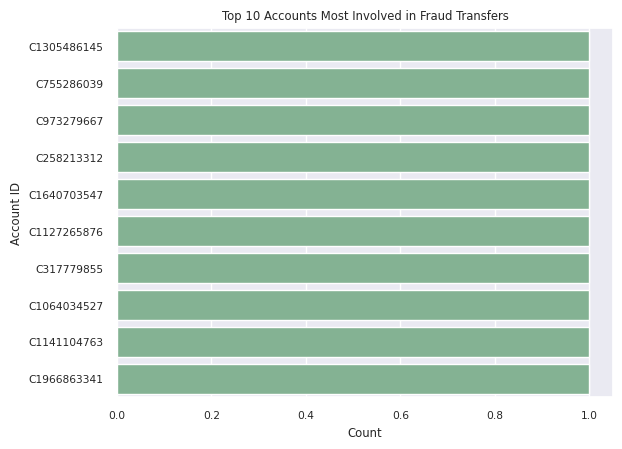

In [ ]:
#plot barplot
sns.set(font_scale = 0.7)
sns.set_palette("crest")
sns.barplot(x=fraud_df["nameOrig"].value_counts().head(10).values, y=fraud_df["nameOrig"].value_counts().head(10).index)
plt.title("Top 10 Accounts Most Involved in Fraud Transfers")
plt.xlabel("Count")
plt.ylabel("Account ID")
plt.show()

I wanted to see if certain accounts dealt more with fraudulent transactions. However, that was not the case. All account IDs are unique and no account engages in a fraudulent transaction more than once. We can also infer that perhaps one person may operate from different accounts.

### d) What do transactions look like day-to-day? Over span of 30 days?

In [ ]:
#add new columns day and hour to keep track of time
paysim_df['day'] = paysim_df['step'] // 24 + 1
paysim_df['hour'] = paysim_df['step'] % 24
fraud_df['day'] = fraud_df['step'] // 24 + 1
fraud_df['hour'] = fraud_df['step'] % 24

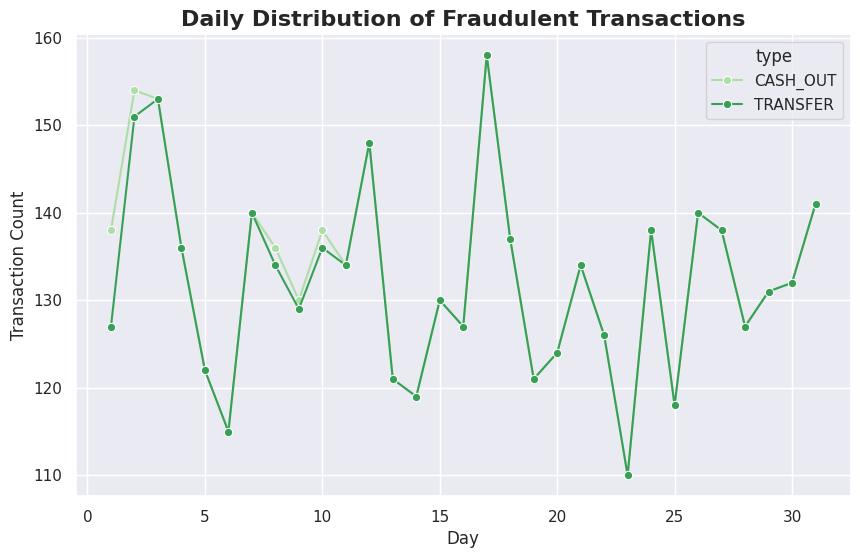

In [ ]:
#plot lineplot
plt.figure(figsize=(10, 6))
daily_df = fraud_df.groupby(['day', 'type']).size().reset_index(name='count')
sns.lineplot(data=daily_df, x="day", y="count", hue="type", marker="o", palette='Greens')
plt.title("Daily Distribution of Fraudulent Transactions", fontsize=16, fontweight='bold')
plt.xlabel("Day", fontsize=12)
plt.ylabel("Transaction Count", fontsize=12)
plt.show()

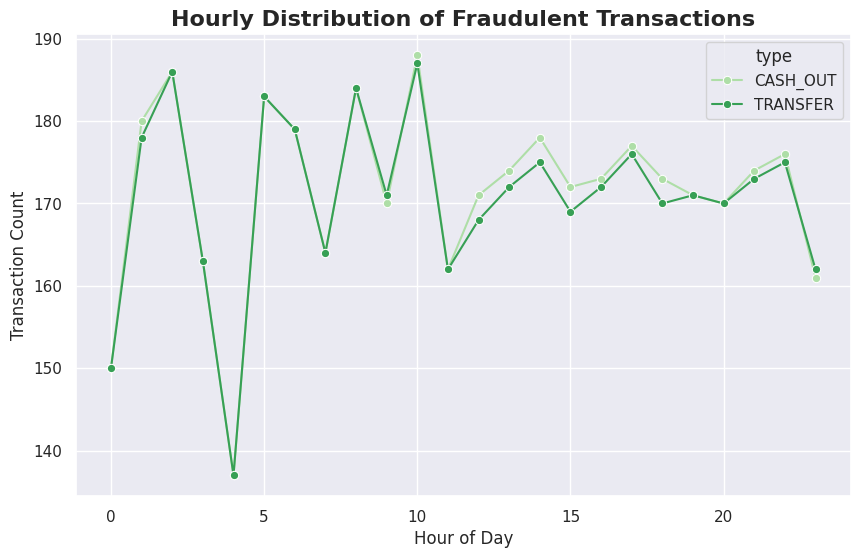

In [ ]:
#plot lineplot
hourly_df = fraud_df.groupby(['hour', 'type']).size().reset_index(name='count')
plt.figure(figsize=(10, 6))
sns.lineplot(data=hourly_df, x="hour", y="count", hue="type", marker="o", palette='Greens')
plt.title("Hourly Distribution of Fraudulent Transactions", fontsize=16, fontweight='bold')
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Transaction Count", fontsize=12)
plt.show()

The two graphs above show the distribution of fraudulent transactions over an hourly and a daily period. We can observe that there is no real pattern to the graph which indicates that time itself is not a good indicator of fraud.

### e)  Amount of flagged fraud transactions?

In [ ]:
print(paysim_df['isFlaggedFraud'].value_counts())

isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64


The graph in b titled "Distribution of Transaction Amounts" shows that not all fraudulent transactions occur in high amounts as is typically assumed. Additionally, the low amount of transactions could occur as a means of avoiding detection. This could also be the reason why there are only 16 positive instances of isFlaggedFraud. The creator of the dataset mentions that only amounts over 200,000 units are flagged as fraud.

### f) What is correlation between all the features?

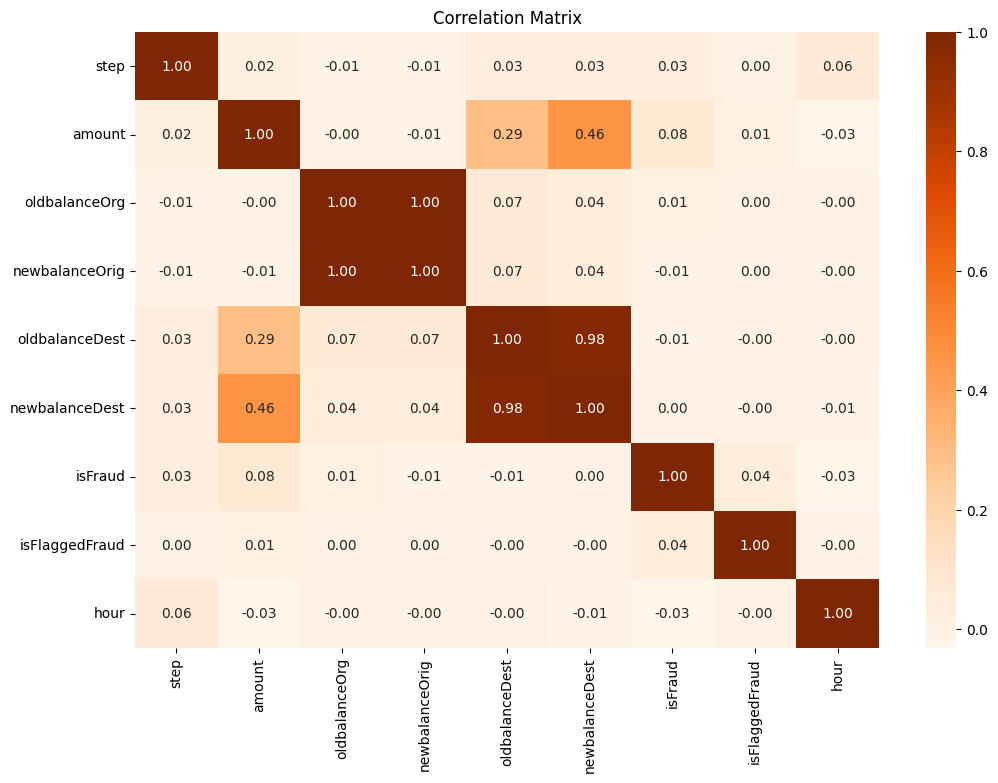

In [ ]:
#include only numeric data and create correlation matrix
numeric_cols = paysim_df.select_dtypes(include=['float64', 'int64']).columns
paysim_corr = paysim_df[numeric_cols].corr()

#plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(paysim_corr, annot=True, cmap='Oranges', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()


The correlation between all the features is not very high – indicating that they don’t have any strong relationships.

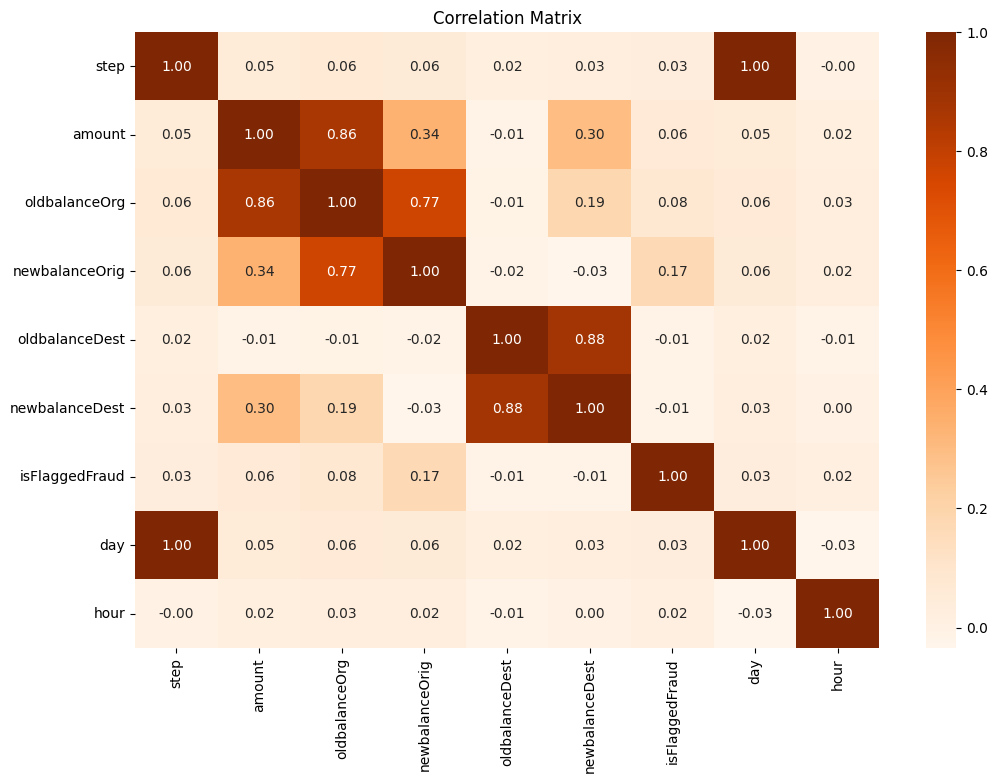

In [ ]:
fraud_df = fraud_df.drop('isFraud', axis=1)

# select numeric columns and calculate correlation matriz
numeric_cols = fraud_df.select_dtypes(include=['float64', 'int64']).columns
fraud_corr = fraud_df[numeric_cols].corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(fraud_corr, annot=True, cmap='Oranges', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

The fraud dataset shows more correlations between features that involve balance and amount. This makes sense since there is a flow of money between accounts.

## 2) Data Preprocessing


In [ ]:
#create new columns for balance difference
paysim_df['diffbalanceOrig'] = paysim_df['newbalanceOrig'] - paysim_df['oldbalanceOrg']
paysim_df['diffbalanceDest'] = paysim_df['newbalanceDest'] - paysim_df['oldbalanceDest']

#drop nameOrig and nameDest
paysim_df.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)

In [ ]:
#calculate the percentage of null values
paysim_df.isnull().sum()*100/len(paysim_df)

,0
step,0.0
type,0.0
amount,0.0
oldbalanceOrg,0.0
newbalanceOrig,0.0
oldbalanceDest,0.0
newbalanceDest,0.0
isFraud,0.0
isFlaggedFraud,0.0
diffbalanceOrig,0.0


In [ ]:
#import for preprocessor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import OneHotEncoder, StandardScaler

#create X and y datasets
X = paysim_df.drop(['isFraud', 'step', 'isFlaggedFraud'], axis=1)
y = paysim_df['isFraud']

#create pipelines for numerical and categorical data
pipeline_numerical = make_pipeline(StandardScaler())
pipeline_categorical = make_pipeline(OneHotEncoder(handle_unknown='ignore'))

#create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', pipeline_numerical, ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'day', 'hour', 'diffbalanceOrig', 'diffbalanceDest']),
        ('cat', pipeline_categorical, ['type'])
    ])


In [ ]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 ['amount', 'oldbalanceOrg', 'newbalanceOrig',
                                  'oldbalanceDest', 'newbalanceDest',
                                  'diffbalanceOrig', 'diffbalanceDest']),
                                ('cat',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['type'])])

In [ ]:
#creating training, validation, and testing sets
from sklearn.model_selection import train_test_split

#seperate 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

#split again for 60% training and 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2/(1-0.2), random_state=124)

X_train_encoded = preprocessor.fit_transform(X_train)
X_train_encoded = pd.DataFrame(X_train_encoded, columns=preprocessor.get_feature_names_out())
X_val_encoded = preprocessor.transform(X_val)
X_test_encoded = preprocessor.transform(X_test)

In [ ]:
#training distribution
y_train.value_counts()

,count
isFraud,
0,3812683
1,4889


In [ ]:
#validation distribution
y_val.value_counts()

,count
isFraud,
0,1270833
1,1691


In [ ]:
#testing distribution
y_test.value_counts()

,count
isFraud,
0,1270891
1,1633


In [ ]:
#create logistic regression model
from sklearn.linear_model import LogisticRegression


LR_model = LogisticRegression(class_weight="balanced")
LR_model.fit(X_train_encoded, y_train)

LogisticRegression(class_weight='balanced')

In [ ]:
#test on validation dataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_predict_LR = LR_model.predict(X_val_encoded)
print(classification_report(y_val, y_predict_LR))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98   1270833
           1       0.03      0.95      0.05      1691

    accuracy                           0.96   1272524
   macro avg       0.51      0.95      0.52   1272524
weighted avg       1.00      0.96      0.98   1272524



In [ ]:
#create random forest model
from sklearn.ensemble import RandomForestClassifier

RF_model = RandomForestClassifier(n_estimators=50, max_depth=5, class_weight='balanced')
RF_model.fit(X_train_encoded, y_train)
y_predict_RF = RF_model.predict(X_val_encoded)
print(classification_report(y_val, y_predict_RF))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98   1270833
           1       0.04      0.98      0.08      1691

    accuracy                           0.97   1272524
   macro avg       0.52      0.97      0.53   1272524
weighted avg       1.00      0.97      0.98   1272524



## 3) Resample Dataset

In [ ]:
#undersample data
from imblearn.under_sampling import InstanceHardnessThreshold
iht = InstanceHardnessThreshold(sampling_strategy=0.1, estimator=LogisticRegression(), random_state=42)
X_train_resample, y_train_resample = iht.fit_resample(X_train_encoded, y_train)

#show distribution
y_train_resample.value_counts()

,count
isFraud,
0,48891
1,4889


In [ ]:
#oversample data
from imblearn.over_sampling import SVMSMOTE
sm = SVMSMOTE(random_state=42, sampling_strategy=0.6)
X_train_resample, y_train_resample = sm.fit_resample(X_train_resample, y_train_resample)

#show distribution
y_train_resample.value_counts()

,count
isFraud,
0,48891
1,29334


## 4) Hyperparameter Tuning

In [ ]:
#import for hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

#dictionary of parameters to test
hyperparameters_RF = dict(n_estimators=randint(50, 300),
                          max_depth=range(3, 15),
                          min_samples_split=uniform(0.1, 1.9),
                          min_samples_leaf=uniform(0.1, 0.9),
                          max_features=['sqrt', 'log2', None]
                          )

#do randomizedsearchcv
RF_model_hp = RandomizedSearchCV(RF_model, hyperparameters_RF,
                                 n_iter=200,
                                 cv=5,
                                 scoring='f1_macro',
                                 verbose=2,
                                 n_jobs=-1,
                                 random_state=42)
#fit resampled data on mode
RF_model_hp.fit(X_train_resample, y_train_resample)

#calculate best model
bestRF_model = RF_model_hp.best_estimator_

#show what best parameters are
bestRF_model

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomForestClassifier(class_weight='balanced', max_depth=12,
                       max_features='log2',
                       min_samples_leaf=0.10635967469774567,
                       min_samples_split=0.14381860757868994, n_estimators=268)

In [ ]:
#validate and show performance of best model
bestRF_model.fit(X_train_resample, y_train_resample)
y_predict_bestRF = bestRF_model.predict(X_val_encoded)
print (classification_report(y_val, y_predict_bestRF))

              precision    recall  f1-score   support

           0       1.00      0.26      0.41   1270833
           1       0.00      1.00      0.00      1691

    accuracy                           0.26   1272524
   macro avg       0.50      0.63      0.21   1272524
weighted avg       1.00      0.26      0.41   1272524



In [ ]:
#dictionary of parameters for logistic regression
hyperparameters_LR = dict(C=np.logspace(-3, 3, 10),
                          solver=['sag', 'saga'],
                          penalty=['l1', 'l2']
                          )
#do randomizedsearchcv
LR_model_hp = RandomizedSearchCV(LR_model, hyperparameters_LR,
                                 n_iter=200,
                                 cv=5,
                                 scoring='f1_macro',
                                 verbose=2,
                                 n_jobs=-1,
                                 random_state=42)

#fit resampled data on model
LR_model_hp.fit(X_train_resample, y_train_resample)

#calculate best model
bestLR_model = LR_model_hp.best_estimator_

#show best parameters
bestLR_model

Fitting 5 folds for each of 40 candidates, totalling 200 fits


LogisticRegression(C=10.0, class_weight='balanced', solver='sag')

In [ ]:
#validate and show performance of best model
bestLR_model.fit(X_train_resample, y_train_resample)
y_predict_bestLR = bestLR_model.predict(X_val_encoded)
print (classification_report(y_val, y_predict_bestLR))

              precision    recall  f1-score   support

           0       1.00      0.08      0.14   1270833
           1       0.00      1.00      0.00      1691

    accuracy                           0.08   1272524
   macro avg       0.50      0.54      0.07   1272524
weighted avg       1.00      0.08      0.14   1272524



In [ ]:
#import StackingClassifier to create ensemble model
from sklearn.ensemble import StackingClassifier

#choose which model to stack
estimators = [
 ('LR', LogisticRegression(class_weight='balanced')),
 ('RF', RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=50)),
 ]

#train and validate model
Stacked_model = StackingClassifier(estimators=estimators)
Stacked_model.fit(X_train_resample, y_train_resample)
y_predict_model = Stacked_model.predict(X_val_encoded)

#print report
print (classification_report(y_val, y_predict_model))


              precision    recall  f1-score   support

           0       1.00      0.07      0.14   1270833
           1       0.00      1.00      0.00      1691

    accuracy                           0.08   1272524
   macro avg       0.50      0.54      0.07   1272524
weighted avg       1.00      0.08      0.14   1272524



## 5) Performance Evaluation

### Confusion Matrices

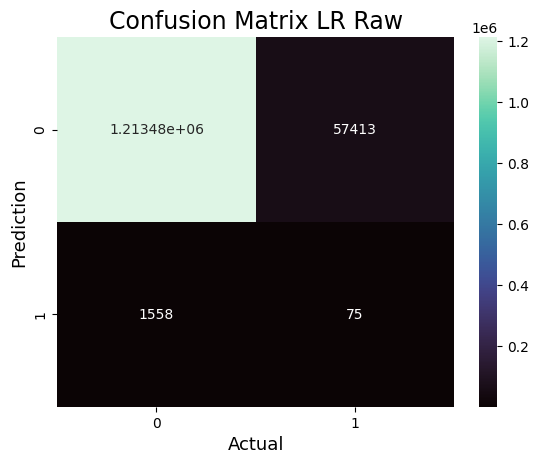

In [ ]:
#create confusion matrix for each model
LR_matrix = confusion_matrix(y_test, y_predict_LR)
RF_matrix = confusion_matrix(y_test, y_predict_RF)
bestRF_matrix = confusion_matrix(y_test, y_predict_bestRF)
bestLR_matrix = confusion_matrix(y_test, y_predict_bestLR)
stacked_matrix = confusion_matrix(y_test, y_predict_model)

#plot for logistic regression raw
sns.heatmap(LR_matrix, annot=True, fmt='g', cmap='mako', cbar=True)
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix LR Raw',fontsize=17)
plt.show()

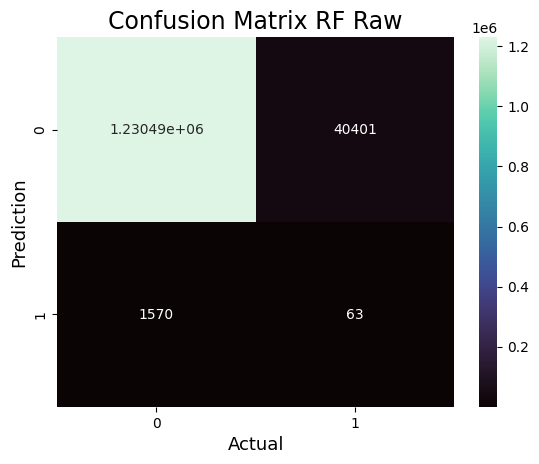

In [ ]:
#plot random forest raw
sns.heatmap(RF_matrix, annot=True, fmt='g', cmap='mako', cbar=True)
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix RF Raw',fontsize=17)
plt.show()

The confusion matrices above run on the logistic regression and random forest models using the raw, unsampled data. As showcased by the light green box, non-fraudulent instances are correctly classified the majority of the time with very few misclassifications. On the other hand, the majority of the fraudulent instances are misclassified as non-fraudulent (roughly 1500 out of 1600). This is very poor performance, despite a high accuracy rate, as it makes the models unusable in real-life scenarios where financial institutions value the detection of fraudulent transactions.

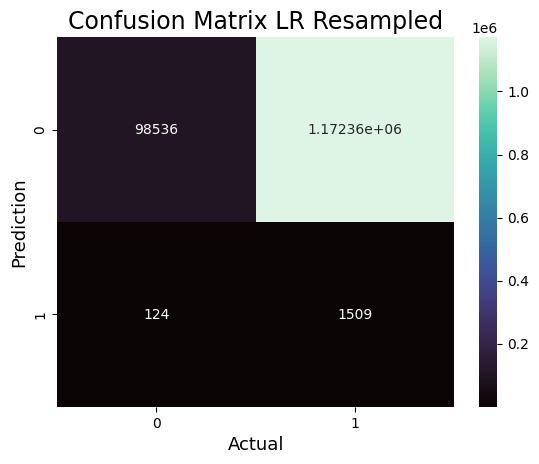

In [ ]:
#plot resampled logistic regression
sns.heatmap(bestLR_matrix, annot=True, fmt='g', cmap='mako', cbar=True)
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix LR Resampled',fontsize=17)
plt.show()

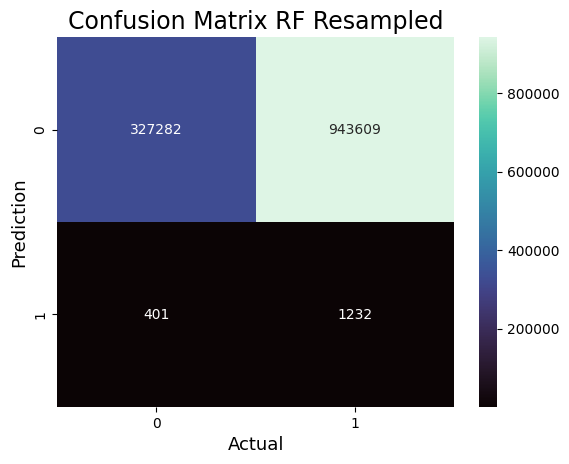

In [ ]:
#plot resampled random forest
sns.heatmap(bestRF_matrix, annot=True, fmt='g', cmap='mako', cbar=True)
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix RF Resampled',fontsize=17)
plt.show()

Running the models on resampled data produces very different results. The notable thing is that the ratio of misclassified fraudulent transactions to correctly identified fraudulent transactions has flipped. While it may seem that the logistic regression model is performing better with a lower misclassification of fraudulent transactions, there is a higher number of misclassifications for non-fraudulent transactions compared to the random forest model. These matrices confirm what had been analyzed earlier with the validation dataset: there is a relationship between precision (incorrectly classifying non-fraudulent transactions) and recall (correctly identified fraudulent transactions)

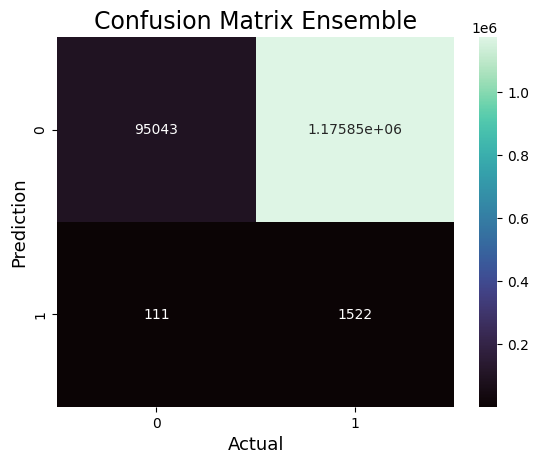

In [ ]:
#plot ensemble model
sns.heatmap(stacked_matrix, annot=True, fmt='g', cmap='mako', cbar=True)
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix Ensemble',fontsize=17)
plt.show()

The ensemble model does not perform any differently from the models that used the resampled data. Its results are closer to the logistic regression model

### ROC Curves

<Figure size 2000x1000 with 0 Axes>

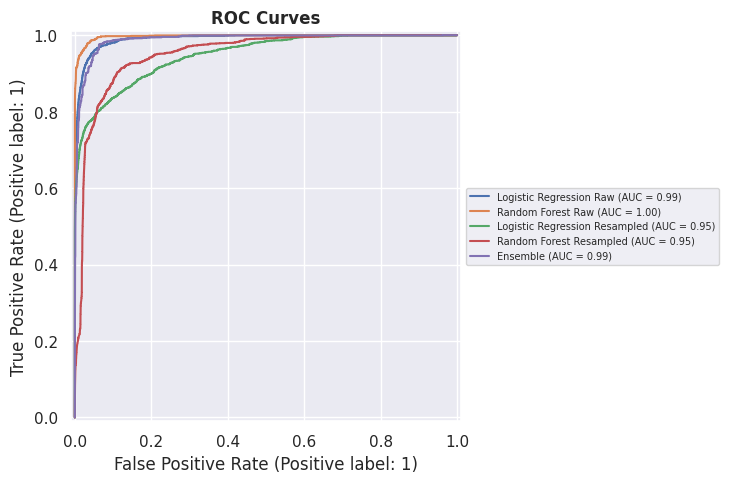

In [ ]:
#import for roc curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score
sns.set(style="darkgrid")
plt.figure(figsize=(20, 10))

#create roc curve plots and display them
LR_plot = RocCurveDisplay.from_estimator(LR_model, X_test_encoded, y_test, linewidth=1.5, name='Logistic Regression Raw')
RF_plot = RocCurveDisplay.from_estimator(RF_model, X_test_encoded, y_test, ax=LR_plot.ax_, linewidth=1.5, name='Random Forest Raw')
LRre_plot = RocCurveDisplay.from_estimator(bestLR_model, X_test_encoded, y_test, ax=LR_plot.ax_, linewidth=1.5, name='Logistic Regression Resampled')
RFre_plot = RocCurveDisplay.from_estimator(bestRF_model, X_test_encoded, y_test, ax=LR_plot.ax_, linewidth=1.5, name='Random Forest Resampled')
stacked_plot = RocCurveDisplay.from_estimator(Stacked_model, X_test_encoded, y_test, ax=LR_plot.ax_, linewidth=1.5, name='Ensemble')
plt.tight_layout()
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5), fontsize=7)
plt.title("ROC Curves", fontweight='bold')
plt.show()

Given what was observed from the confusion matrices, the ROC curves may look a bit contradictory at first glance. The true positive rate (TPR) is the rate at which fraudulent data was correctly identified. The false positive rate (FPR), on the other hand, is the rate at which non-fraudulent data was incorrectly identified as fraudulent. The area under the curve (AUC) – which is at 0.95 or above for all models – signifies they perform exceptionally well according to this graph. However, that is not the case. Instead, the good performance of these models denotes that this graph is not useful in determining the models’ behaviour.

The models using the raw dataset have a very poor performance for TPR. The confusion matrices showed us how fraudulent data is misclassified. However, it also correctly predicts all non-fraudulent cases – meaning the amount of false positives is low. As a result, the curve shows a good performance that is only affecting the majority class (non-fraudulent transactions).

The models using the resampled dataset (including the ensemble model) perform very well in identifying true positives – the correct classification of fraudulent data. However, as a result, it also has a high number of false positives – the misclassification of non-fraudulent data. The high TPR balances the high FPR which affects the curve and makes it seem as though the model is performing well.

### Precision-Recall Curves

From all the analysis done so far, it is evident that the relationship between precision and recall is very important in determining how the model is performing. Thus, the precision-recall curve is one of the most helpful graphs in understanding that relationship.

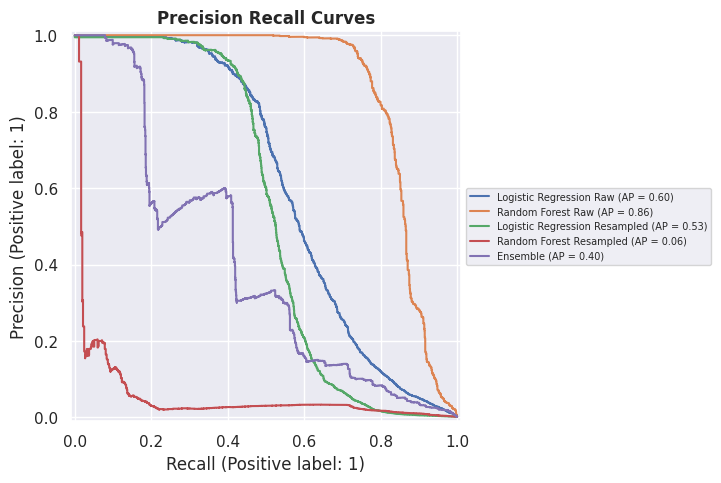

In [ ]:
#import for precision-recall curves
from sklearn.metrics import PrecisionRecallDisplay

#plot precision-recall curve plots
LR_plot = PrecisionRecallDisplay.from_estimator(LR_model, X_test_encoded, y_test, linewidth=1.5, name='Logistic Regression Raw')
RF_plot = PrecisionRecallDisplay.from_estimator(RF_model, X_test_encoded, y_test, ax=LR_plot.ax_, linewidth=1.5, name='Random Forest Raw')
LRre_plot = PrecisionRecallDisplay.from_estimator(bestLR_model, X_test_encoded, y_test, ax=LR_plot.ax_, linewidth=1.5, name='Logistic Regression Resampled')
RFre_plot = PrecisionRecallDisplay.from_estimator(bestRF_model, X_test_encoded, y_test, ax=LR_plot.ax_, linewidth=1.5, name='Random Forest Resampled')
stacked_plot = PrecisionRecallDisplay.from_estimator(Stacked_model, X_test_encoded, y_test, ax=LR_plot.ax_, linewidth=1.5, name='Ensemble')
plt.tight_layout()
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5), fontsize=7)
plt.title("Precision Recall Curves", fontweight='bold')
plt.show()

For the models using the raw datasets – along with the logistic regression model that uses the resampled dataset – there is a noticeable decline in the precision metric as the recall metric increases. The ensemble model is also somewhere in between where it struggles to maintain a good precision metric with the improvement of the recall metric. The worst-performing model is the random forest model with the resampled dataset. Its precision is almost non-existent even with lower recall. From the graph, the key takeaway is that most models will have some form of a trade-off between precision and recall and the main struggle is to maintain that balance.

## 6) Limitations and Possible Solutions

With all the analyses, it is evident that the models’ performance has limitations that are affected by various factors – some that are easy to solve while others are more difficult. One such issue is that the resampled data utilized both undersampling and oversampling techniques. This could have made the data more biased towards the minority model which could have affected the performance. This can be rectified by either employing only one resampling technique or combining both techniques through methods like SMOTEENN or SMOTETomek.

Even with the resampling, it is important to remember that these techniques can only be used on the training set. The validation and test sets are still severely imbalanced which can also hinder model performance. This is likely indicative of the model overfitting the training data – in which case the only solution is to try and test other resampling methods (like the ones mentioned above).

Another possible limitation is the models themselves. As mentioned before, logistic regression is a simple model. Random forest, although an ensemble model, may not be enough to recognize the patterns within the dataset. There are other ensemble models like AdaBoost or GradientBoost that can be utilized to better fit the data.

Finally, the biggest issue encountered was the computational costs of training and tuning the model. One of the reasons I didn’t just oversample the data was because of how large it could become. Consequently, hyperparameter tuning was computationally expensive depending on what parameters I wanted to test. As a result, it severely restricted the choices I could use. Unfortunately, this is an issue that cannot be solved easily.

## 7) Conclusion

The main challenge of this project was working the imbalanced PaySim dataset to correctly predict fraudulent transactions while preserving model integrity. In an attempt to accomplish this, several techniques were used. First, the dataset was undersampled using the InstanceHardnessTreshold() and then oversampled using the SVMSMOTE. Additionally, I used another ensemble model – the StackingClassifier(). There was also hyperparameter tuning to find the best parameters for the models.

In the end, I was able to create models that could correctly identify fraudulent transactions – however, it came with the cost of low precision. Confusion matrices, ROC curves, and most importantly, precision-recall curves all showcase that there is a trade-off between precision and recall when it comes to imbalanced datasets such as these.

Going back to the purposes of this project – we can see that these models are not suitable to be deployed in the real world because they would classify an overwhelming amount of non-fraudulent transactions as fraudulent. Of course, there is a way to work around that. Instead of letting the models be the final judge, there could be a team of people monitoring and investigating those that the models have classified as fraudulent – in other words letting the models create a watchlist of sorts. The main point here is that several areas still exist where machine learning is not the ultimate solution to the problem. Whether it is creating, deploying, or monitoring the models – humans will always have a role to play.